# Assignment 6 — PPO

Abhinav Kumar
12/14/2025

In [1]:
from pathlib import Path
import shutil

src = Path("agent_vectorized.py")
bak = Path("agent_vectorized.py.bak")

if not bak.exists():
    shutil.copy2(src, bak)
    print("Backup created:", bak)
else:
    print("Backup already exists:", bak)


Backup already exists: agent_vectorized.py.bak


In [2]:
from pathlib import Path
import re

path = Path("agent_vectorized.py")
txt = path.read_text(encoding="utf-8")

txt = re.sub(
    r"device\s*=\s*'cuda'\s*if\s*torch\.cuda\.is_available\(\)\s*else\s*'cpu'",
    "device = 'cpu'",
    txt
)

txt = re.sub(r"nb_actor\s*=\s*8", "nb_actor = 2", txt)

txt = re.sub(r"batch_size\s*=\s*512", "batch_size = 64", txt)

# PPO signature defaults: T, K, batch_size, nb_iterations
txt = re.sub(r"def PPO\(([\s\S]*?)T\s*=\s*128", r"def PPO(\1T=32", txt, count=1)
txt = re.sub(r"def PPO\(([\s\S]*?)K\s*=\s*3",   r"def PPO(\1K=1",  txt, count=1)
txt = re.sub(r"def PPO\(([\s\S]*?)batch_size\s*=\s*256", r"def PPO(\1batch_size=64", txt, count=1)
txt = re.sub(r"nb_iterations\s*=\s*40_000", "nb_iterations=80", txt)

txt = txt.replace("if (iteration % 400 == 0) and iteration > 0:", "if (iteration % 5 == 0) and iteration > 0:")

path.write_text(txt, encoding="utf-8")
print("Patched agent_vectorized.py ✅ (tiny CPU run: nb_iterations=80, T=32, K=1, nb_actor=2, batch_size=64, log every 5 iters)")


Patched agent_vectorized.py ✅ (tiny CPU run: nb_iterations=80, T=32, K=1, nb_actor=2, batch_size=64, log every 5 iters)


In [3]:
!uv run python agent_vectorized.py

Using device: cpu
Training with 2 parallel environments
Batch size: 64

Estimated GPU memory per batch: 6.9 MB
Estimated total memory usage: 0.02 GB
Recommendation: Use batch_size = 64 for balanced GPU utilization
             or batch_size=1024 if you have 16+ GB VRAM
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]

Model parameters: 677,429
Starting training...

100%|███████████████████████████████████████████| 80/80 [00:26<00:00,  2.97it/s]

Total training time: 0.01 hours


In [4]:
from pathlib import Path

logdir = Path("runs") / "breakout_ppo"
event_files = sorted(logdir.rglob("events.out.tfevents.*"), key=lambda p: p.stat().st_mtime, reverse=True)

print("Logdir:", logdir, "exists:", logdir.exists())
print("Event files found:", len(event_files))
if event_files:
    print("Newest:", event_files[0])


Logdir: runs/breakout_ppo exists: True
Event files found: 2
Newest: runs/breakout_ppo/events.out.tfevents.1765769054.549d66c1ea57.94580.0


Scalar tags: ['Training/policy_loss', 'Training/value_loss', 'Training/entropy', 'Training/learning_rate', 'Average_Reward/env_0', 'Average_Reward/env_1', 'Average_Reward/all_envs']


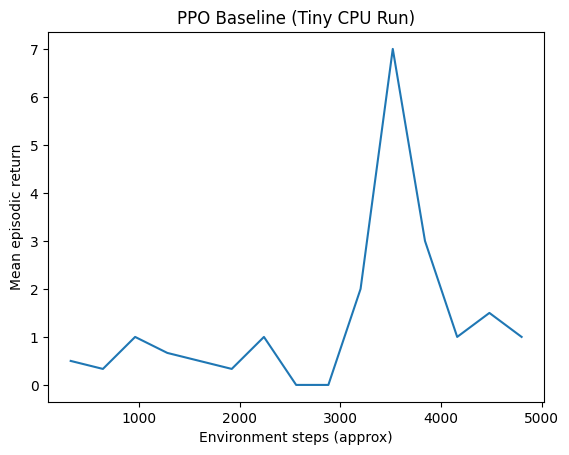

Points: 15
Last value: 1.0


In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

logdir = Path("runs") / "breakout_ppo"
event_files = sorted(logdir.rglob("events.out.tfevents.*"), key=lambda p: p.stat().st_mtime, reverse=True)
event_path = event_files[0]

ea = EventAccumulator(str(event_path))
ea.Reload()

tag = "Average_Reward/all_envs"
tags = ea.Tags().get("scalars", [])
print("Scalar tags:", tags)

if tag not in tags:
    raise ValueError(f"'{tag}' not found. Use one of the tags printed above.")

events = ea.Scalars(tag)
iters = [e.step for e in events]
vals  = [e.value for e in events]

T = 32
nb_actor = 2
steps = [it * (T * nb_actor) for it in iters]

plt.figure()
plt.plot(steps, vals)
plt.xlabel("Environment steps (approx)")
plt.ylabel("Mean episodic return")
plt.title("PPO Baseline (Tiny CPU Run)")
plt.show()

print("Points:", len(vals))
print("Last value:", vals[-1] if vals else None)


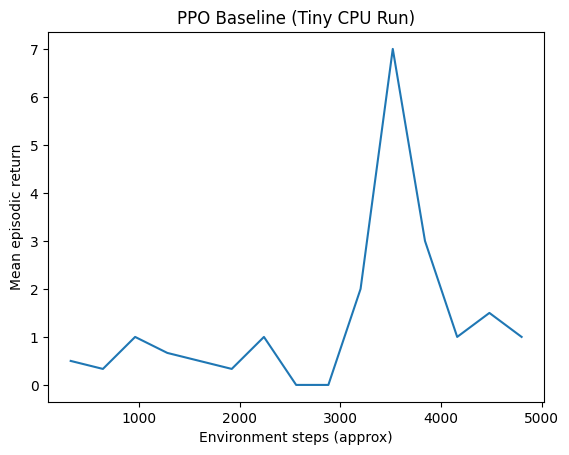

Saved: /workspaces/eng-ai-agents/assignments/assignment-6/figures/ppo_curve.png


In [7]:
from pathlib import Path
import matplotlib.pyplot as plt

outpath = Path("figures") / "ppo_curve.png"

plt.figure()
plt.plot(steps, vals)
plt.xlabel("Environment steps (approx)")
plt.ylabel("Mean episodic return")
plt.title("PPO Baseline (Tiny CPU Run)")
plt.savefig(outpath, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", outpath.resolve())
